In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import signal as sig
from utils import preprocessing, constants, frequency, transforms
import matplotlib.pyplot as plt
from scipy import interpolate as interp

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
cwd = Path.cwd()
csv_dir = cwd / "data"
# csv_dir = cwd / "norlab-data"

# Random state
RANDOM_STATE = 21

# Define channels
columns = {
    "imu": {
        "wx": True,
        "wy": True,
        "wz": True,
        "ax": True,
        "ay": True,
        "az": True,
    },
    "pro": {
        "velL": True,
        "velR": True,
        "curL": True,
        "curR": True,
    },
}
summary = pd.DataFrame({"columns": pd.Series(columns)})

In [4]:
# Get recordings
terr_dfs = preprocessing.get_recordings(csv_dir, summary)

# Set data partition parameters
NUM_CLASSES = len(np.unique(terr_dfs["imu"].terrain))
N_FOLDS = 5
PART_WINDOW = 5  # seconds
MOVING_WINDOWS = [1.5, 1.6, 1.7, 1.8]  # seconds
# Data augmentation parameters
# 0 < STRIDE < MOVING_WINDOWS
STRIDE = 0.1  # seconds
# If True, balance the classes while augmenting
# If False, imbalance the classes while augmenting
HOMOGENEOUS_AUGMENTATION = True

# tw / to
tw = 0.4
to = 0.2

In [5]:
# terr = "SANDY_LOAM"
terr = "DIRT_ROAD"
exps = {
    sens: sens_data[sens_data.terrain == terr] for sens, sens_data in terr_dfs.items()
}
run_dfs = {
    sens: sens_data[sens_data.run_idx == 1] for sens, sens_data in exps.items()
}
run_dfs["imu"].run_idx.value_counts()

run_idx
1    4044
Name: count, dtype: int64

In [6]:
run_dfs["imu"].columns

Index(['time', 'wx', 'wy', 'wz', 'ax', 'ay', 'az', 'terrain', 'run_idx'], dtype='object')

In [7]:
# Data partition and sample extraction
all_data = preprocessing.partition_data(
    run_dfs,
    summary,
    PART_WINDOW,
    n_splits=None,
    random_state=RANDOM_STATE,
)
run_data = {sens: np.vstack(sens_data)[np.newaxis, :] for sens, sens_data in all_data.items()}

In [8]:
hamm = frequency.multichannel_spectrogram(
    run_data,
    summary,
    50,
    tw,
    to,
    hamming=True,
)
nohamm = frequency.multichannel_spectrogram(
    run_data,
    summary,
    50,
    tw,
    to,
    hamming=False,
)

In [9]:
(hamm["time"] == nohamm["time"]).all(), (hamm["freq"] == nohamm["freq"]).all()

(True, True)

In [10]:
hmcs_freq = hamm["freq"]
hmcs_time = hamm["time"]
hmcs_data = hamm["data"][0]
nmcs_freq = nohamm["freq"]
nmcs_time = nohamm["time"]
nmcs_data = nohamm["data"][0]
hmcs_data.shape, nmcs_data.shape


((11, 248, 10), (11, 248, 10))

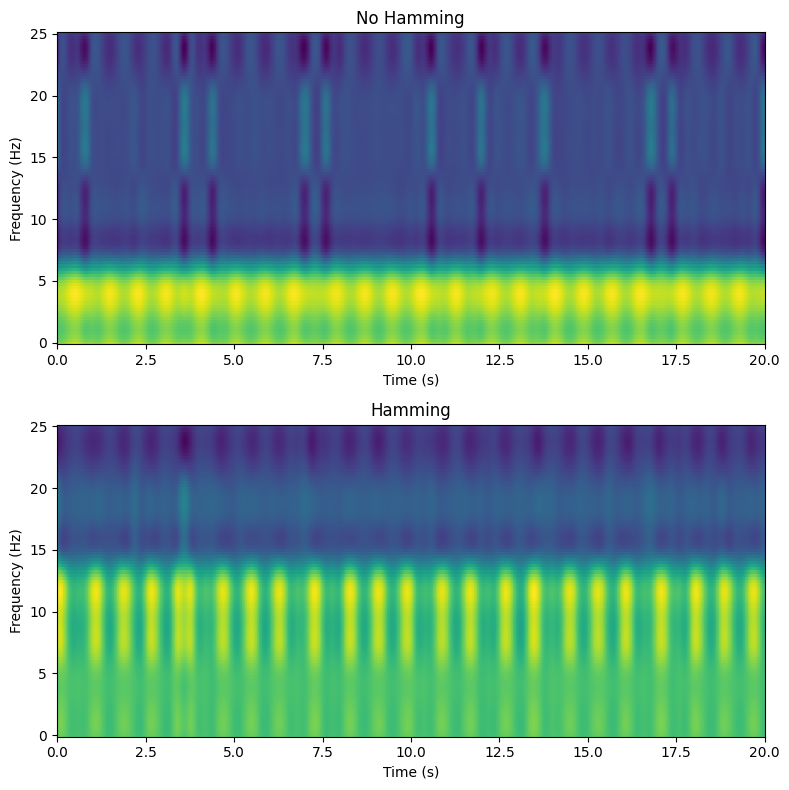

In [11]:
fig, axs = plt.subplots(nrows=2, figsize=(8, 8))

t_mcs = nmcs_time[0, :, 0]
f_mcs = nmcs_freq[:, 0, 0]
d_mcs = nmcs_data[:, :, 6]
f = interp.interp2d(t_mcs, f_mcs, d_mcs, kind="cubic")
tnew = transforms.expand(t_mcs)
fnew = transforms.expand(f_mcs)
dnew = f(tnew, fnew)
tN, fN = np.meshgrid(tnew, fnew)

axs[0].pcolor(tN - tw, fN, dnew)
axs[0].set_title("No Hamming")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_xlabel("Time (s)")

t_mcs = hmcs_time[0, :, 0]
f_mcs = hmcs_freq[:, 0, 0]
d_mcs = hmcs_data[:, :, 6]
f = interp.interp2d(t_mcs, f_mcs, d_mcs, kind="cubic")
tnew = transforms.expand(t_mcs)
fnew = transforms.expand(f_mcs)
dnew = f(tnew, fnew)
tN, fN = np.meshgrid(tnew, fnew)

axs[1].pcolor(tN - tw, fN, dnew)
axs[1].set_title("Hamming")
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_xlabel("Time (s)")

axs[0].set_xlim(right=20)
axs[1].set_xlim(right=20)

fig.tight_layout()

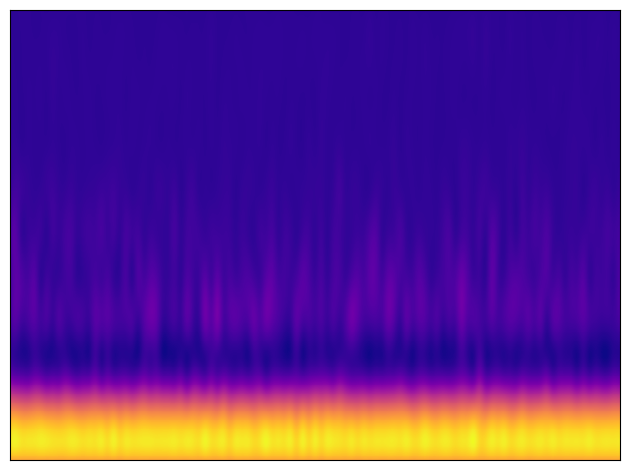

In [12]:
fig, ax = plt.subplots()
t_mcs = hmcs_time[0, :, 0]
f_mcs = hmcs_freq[:, 0, 0]
d_mcs = hmcs_data[:, :, 5]
f = interp.interp2d(t_mcs, f_mcs, d_mcs, kind="cubic")
tnew = transforms.expand(t_mcs, mult=50)
fnew = transforms.expand(f_mcs, mult=50)
dnew = f(tnew, fnew)
tN, fN = np.meshgrid(tnew, fnew)

ax.pcolormesh(tN - tw, fN, dnew, cmap="plasma")
# ax.set_ylabel("Frequency (Hz)")
# ax.set_xlabel("Time (s)")

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim(right=20)

fig.tight_layout()